# Calculate vertical actions for Kepler stars.

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
from scipy.stats import gamma
import requests
from io import BytesIO
from actions import action

In [49]:
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

Download the KIC to get all the properties then crossmatch with Megan's table. 

In [50]:
stlr = get_catalog("q1_q16_stellar")

Make cuts on the stellar catalogue.

In [51]:
# Select G and K dwarfs.
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Lines to change for different stellar parameters.
var_names = ["koi_period", "koi_prad", "teff"]

period_rng = (50, 300)
radius_rng = (0.75, 2.5)
teff_rng = (4200, 6101)

(91446, 99)


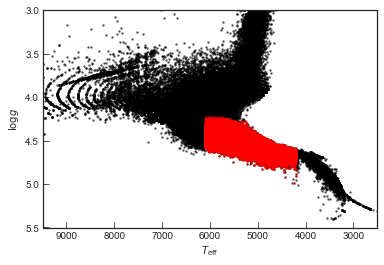

In [52]:
plt.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
plt.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");
print(np.shape(stlr))

Then crossmatch the exopop catalogues with the Gaia-Kepler catalogue.

In [53]:
dat = Table.read('kepler_dr2_4arcsec_updated.fits', format='fits')
d = dat.to_pandas()
m = 10 < d.parallax_over_error.values # Signal to noise greater than 10.
df = d.iloc[m]
print(np.shape(d)[0] - np.shape(df)[0], "stars in Gaia with too low S/N")
print(np.shape(df)[0], "stars in Gaia remaining")

48794 stars in Gaia with too low S/N
184050 stars in Gaia remaining


In [54]:
stlr_gaia = pd.merge(stlr, df, on="kepid", how="inner", suffixes=["_stlr", "_bedell"])
print(np.shape(stlr)[0], "stars in the KIC with cuts on stellar properties")
print(np.shape(df)[0], "stars in Kepler-Gaia with good parallaxes")
print(np.shape(stlr_gaia)[0], "stars with cuts on stellar properties and good parallaxes")

91446 stars in the KIC with cuts on stellar properties
184050 stars in Kepler-Gaia with good parallaxes
85492 stars with cuts on stellar properties and good parallaxes


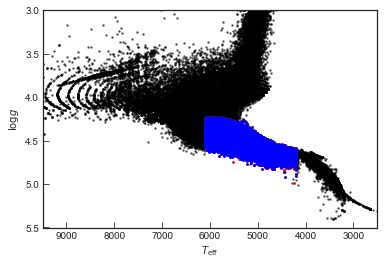

In [55]:
plt.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
plt.plot(stlr.teff, stlr.logg, ".r", ms=3)
plt.plot(stlr_gaia.teff_stlr, stlr_gaia.logg_stlr, ".b", ms=3)
plt.xlim(9500, 2500)
plt.ylim(5.5, 3)
plt.ylabel("$\log g$");
plt.xlabel("$T_\mathrm{eff}$");

Calculate tangential velocities for these stars.

In [56]:
vel_ra = stlr_gaia.pmra.values / stlr_gaia.parallax.values
vel_dec = stlr_gaia.pmdec.values / stlr_gaia.parallax.values
TV = np.sqrt(vel_ra**2 + vel_dec**2)

Calculate vertical actions for all those stars.

In [58]:
os.remove("results/actions.txt")

jrs, lzs, jzs, z, vzs, vrs, vts = [np.zeros(len(stlr_gaia.kepid.values)) for i in range(7)]
with open("results/actions.txt", "a") as f:
    f.write("J_R,L_z,J_Z")
    for i, star in enumerate(stlr_gaia.kepid.values):
        
        # If there is no RV measurement, replace NaN with zero.
        RV = stlr_gaia.radial_velocity[i]*1
        if np.isnan(RV):
            RV = 0.
            
        # Calculate actions
        R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, lz, Jz = \
                action(stlr_gaia.ra_bedell.values[i],
                       stlr_gaia.dec_bedell.values[i], 
                       stlr_gaia.r_est.values[i]*1e-3,  # distance needs to be in kpc 
                       stlr_gaia.pmra.values[i], 
                       stlr_gaia.pmdec.values[i], RV)
           
        jrs[i] = jR
        lzs[i] = lz
        jzs[i] = Jz
        z[i] = z_kpc
        vts[i] = vT_kms
        vzs[i] = vz_kms
        vrs[i] = vR_kms
        
        if i % 1000 == 0:
            print(i, "of", len(stlr_gaia.kepid.values))
            print(z[i])
        f.write("{},{},{}".format(jrs[i], lzs[i], jzs[i]))

0 of 85492
0.1919228366449349
1000 of 85492
0.6190699837336688
2000 of 85492
0.2948606548429338
3000 of 85492
0.2835660100509227
4000 of 85492
0.24230172788532217
5000 of 85492
0.282273602066353
6000 of 85492
0.26628138212202646
7000 of 85492
0.44036692216405965
8000 of 85492
0.1521940052450163
9000 of 85492
0.18706575138325657
10000 of 85492
0.20830126043507557
11000 of 85492
0.18983920805600776
12000 of 85492
0.2322367511630661
13000 of 85492
0.23664074955383727
14000 of 85492
0.31499368255125637
15000 of 85492
0.09941783560441375
16000 of 85492
0.16670137945815477
17000 of 85492
0.15876390085926967
18000 of 85492
0.12589821966018508
19000 of 85492
0.24772117777012062
20000 of 85492
0.19642164122025071
21000 of 85492
0.4336288693447729
22000 of 85492
0.4042313807855723
23000 of 85492
0.1427041556930176
24000 of 85492
0.14443077923476585
25000 of 85492
0.3279635909998452
26000 of 85492
0.29076333690009337
27000 of 85492
0.13337007656705813
28000 of 85492
0.19210138008357597
29000 of 8

In [59]:
stlr_gaia["J_R"] = jrs
stlr_gaia["L_z"] = lzs
stlr_gaia["J_z"] = jzs
stlr_gaia["Z"] = z
stlr_gaia["vR_kms"] = vrs
stlr_gaia["cT_kms"] = vT_kms
stlr_gaia["vz_kms"] = vzs
#stlr_gaia["tangential_velocity"] = TV
#print(TV)

print(stlr_gaia.vz_kms)
stlr_gaia.to_csv("stlr_gaia_actions.csv")

0        -0.154677
1        19.387949
2        14.158278
3        35.467766
4       -16.229527
5       -23.204460
6       -10.060952
7        -8.717084
8       -29.422059
9         8.580957
10      -30.982994
11      -71.343953
12        4.078924
13      -18.379405
14        2.195294
15       19.555770
16       20.935268
17       14.329094
18      -33.377714
19       -1.237860
20       13.690590
21       52.226020
22       -5.102652
23       -0.633170
24       21.148827
25       47.140060
26        2.923337
27      -48.817011
28       -5.722184
29      -16.481279
           ...    
85462     0.630714
85463     7.036276
85464     9.224085
85465   -29.053498
85466    -3.260484
85467    19.755979
85468    15.621523
85469     7.542678
85470     5.445606
85471    14.306540
85472    -8.302477
85473     3.989587
85474     2.885373
85475     0.564491
85476    15.239264
85477    21.992099
85478    -3.420484
85479    -1.682938
85480    -1.637811
85481    -2.841495
85482    -0.663448
85483    -0.

(-0.001, 0.001)

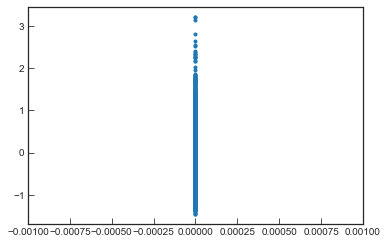

In [52]:
plt.plot(TV, np.log10(z), ".")

In [40]:
#plt.hist(stlr_gaia.J_z.values, 100)
print(stlr_gaia.J_z.values)

[ 2.32059556 14.10978163 11.00841909 ... 79.72770596 11.0246145
 14.53391141]


In [73]:
stlr_gaia.to_csv("stlr_gaia_actions.csv")

Now just the stars in Megan's catalogue?

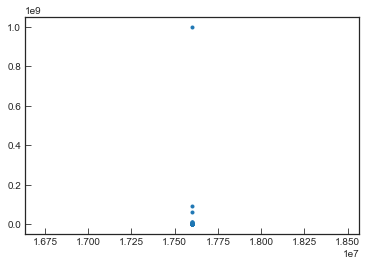

In [45]:
m = jrs > 1e7
plt.plot(jrs[m], jzs[m], ".")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':



Text(0,0.5,'log10 Jz')

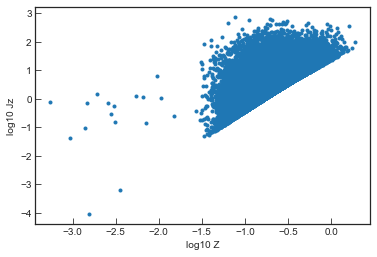

In [72]:
plt.plot(np.log10(z), np.log10(jzs), ".")
plt.xlabel("log10 Z")
plt.ylabel("log10 Jz")